# 👾 PixelCNN from scratch

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset from scratch

The code has been adapted from the excellent [PixelCNN tutorial](https://keras.io/examples/generative/pixelcnn/) created by ADMoreau, available on the Keras website.

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/generative

Mounted at /content/drive
/content/drive/MyDrive/generative


In [ ]:
# Download database from Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/generative/data/epirecipes"
!mkdir -p /content/drive/MyDrive/generative/data/epirecipes
%cd /content/drive/MyDrive/generative/data/epirecipes
%ls -l
#!kaggle datasets download -d hugodarwood/epirecipes --unzip --force
%ls -l
%cd /content/drive/MyDrive/generative

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

from notebooks.utils import display

## 0. Parameters <a name="parameters"></a>

In [4]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Prepare the data <a name="prepare"></a>

In [5]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

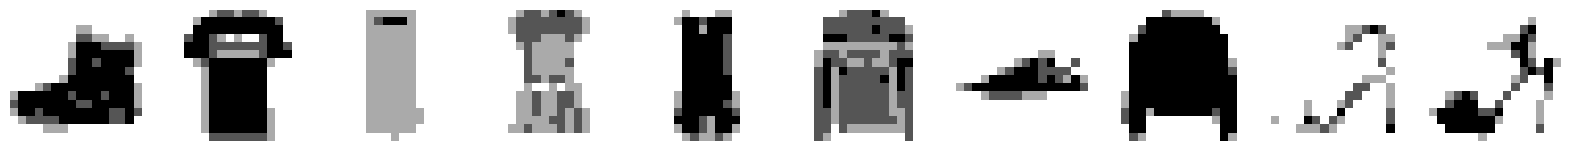

In [7]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN

In [8]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [9]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [10]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2  (None, 16, 16, 128)       6400      
 D)                                                              
                                                                 
 residual_block (ResidualBl  (None, 16, 16, 128)       53504     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_2 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                      

## 3. Train the PixelCNN <a name="train"></a>

In [11]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [12]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

In [14]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

Epoch 1/150
  3/469 [..............................] - ETA: 12:50 - loss: 0.4130

KeyboardInterrupt: 

## 4. Generate images <a name="generate"></a>

In [ ]:
generated_images = img_generator_callback.generate(temperature=1.0)

In [ ]:
display(generated_images)